## DataFrame benchmarks with object vs. string[pyarrow] data

In [1]:
import dask
dask.utils.show_versions()

{
  "Python": "3.11.0",
  "Platform": "Darwin",
  "dask": "2023.3.2",
  "distributed": "2023.3.2",
  "numpy": "1.24.2",
  "pandas": "2.0.0rc1",
  "cloudpickle": "2.2.1",
  "fsspec": "2023.3.0",
  "bokeh": "2.4.3",
  "fastparquet": null,
  "pyarrow": "11.0.0",
  "zarr": null
}

In [2]:
import pandas as pd
import numpy as np
from dask.sizeof import sizeof
from dask.utils import format_bytes
from dask import delayed
from dask.distributed import PipInstall, PackageInstall
import dask.dataframe as dd
import random
import string
from distributed import wait
from distributed import Client
from distributed.diagnostics import MemorySampler
import coiled
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from dask.distributed import performance_report

In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
cluster

LocalCluster(91bb323b, 'tcp://127.0.0.1:62045', workers=4, threads=12, memory=64.00 GiB)

In [5]:
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62045,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:62056,Total threads: 3
Dashboard: http://127.0.0.1:62060/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:62048,


In [6]:
columns = ["store_and_fwd_flag"]
# columns = ["VendorID", "passenger_count", "trip_distance", "store_and_fwd_flag", "total_amount"]

In [7]:
file_paths = [
    f"s3://nyc-tlc/trip data/yellow_tripdata_{year}*.parquet"
    for year in (2020, 2021, 2022)
]
file_paths

['s3://nyc-tlc/trip data/yellow_tripdata_2020*.parquet',
 's3://nyc-tlc/trip data/yellow_tripdata_2021*.parquet',
 's3://nyc-tlc/trip data/yellow_tripdata_2022*.parquet']

In [8]:
def get_ddf(persist=False):
    ddf = dd.read_parquet(file_paths, columns=columns)
    return ddf.persist() if persist else ddf

In [9]:
def get_ddf2(persist=False):
    with dask.config.set({"dataframe.convert_string": True}):
        ddf2 = dd.read_parquet(file_paths, columns=columns)
        return ddf2.persist() if persist else ddf2

## Memory usage

In [10]:
from dask.utils import format_bytes

In [74]:
ddf = get_ddf(True)

In [66]:
format_bytes(ddf.store_and_fwd_flag.memory_usage(deep=True).compute())

'5.03 GiB'

In [72]:
ddf2 = get_ddf2(True)

In [68]:
format_bytes(ddf2.store_and_fwd_flag.memory_usage(deep=True).compute())

'461.86 MiB'

In [69]:
memory_usage_object = ddf.memory_usage_per_partition().compute().apply(format_bytes)
memory_usage_object

0     48.87 MiB
1     48.06 MiB
2     22.95 MiB
3      1.82 MiB
4      2.66 MiB
5      4.19 MiB
6      6.11 MiB
7      7.69 MiB
8     10.23 MiB
9     12.83 MiB
10    11.51 MiB
11    11.15 MiB
12    10.45 MiB
13    10.47 MiB
14    14.69 MiB
15    16.56 MiB
16    19.13 MiB
17    21.62 MiB
18    21.53 MiB
19    21.28 MiB
20    22.61 MiB
21    26.42 MiB
22    26.50 MiB
23    24.52 MiB
24    18.80 MiB
25    22.73 MiB
26    27.68 MiB
27    27.47 MiB
28    27.38 MiB
29    27.15 MiB
30    24.22 MiB
31    24.05 MiB
32    24.29 MiB
33    28.04 MiB
34    24.82 MiB
35    25.94 MiB
dtype: object

In [70]:
memory_usage_string = ddf2.memory_usage_per_partition().compute().apply(format_bytes)
memory_usage_string

0     31.24 MiB
1     30.74 MiB
2     14.66 MiB
3      1.15 MiB
4      1.65 MiB
5      2.64 MiB
6      3.85 MiB
7      4.86 MiB
8      6.47 MiB
9      8.12 MiB
10     7.28 MiB
11     7.05 MiB
12     6.60 MiB
13     6.61 MiB
14     9.29 MiB
15    10.49 MiB
16    12.13 MiB
17    13.74 MiB
18    13.67 MiB
19    13.50 MiB
20    14.35 MiB
21    16.80 MiB
22    16.85 MiB
23    15.61 MiB
24    11.97 MiB
25    14.47 MiB
26    17.62 MiB
27    17.48 MiB
28    17.41 MiB
29    17.26 MiB
30    15.41 MiB
31    15.32 MiB
32    15.45 MiB
33    17.84 MiB
34    15.78 MiB
35    16.50 MiB
dtype: object

## Running time

In [86]:
client.restart();

2023-03-29 17:37:25,211 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:37:25,233 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:37:25,234 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:37:25,242 - distributed.nanny - WARNING - Restarting worker


In [87]:
ddf = get_ddf(True)

In [88]:
wait(ddf);

In [91]:
%timeit -r 5 -n 2 ddf.store_and_fwd_flag.unique().compute()

The slowest run took 181.73 times longer than the fastest. This could mean that an intermediate result is being cached.
195 ms ± 180 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [92]:
%timeit -r 5 -n 2 ddf.groupby("store_and_fwd_flag").count().compute()

The slowest run took 157.13 times longer than the fastest. This could mean that an intermediate result is being cached.
337 ms ± 312 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [93]:
%timeit -r 5 -n 2 ddf.store_and_fwd_flag.str.startswith("a").compute()

5.78 s ± 47.1 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [95]:
%timeit -r 5 -n 2 ddf.store_and_fwd_flag.str.len().compute()

3.69 s ± 8.72 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [96]:
client.restart();

2023-03-29 17:41:46,545 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:41:46,598 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:41:46,600 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:41:46,601 - distributed.nanny - WARNING - Restarting worker


In [97]:
ddf2 = get_ddf2(True)

In [98]:
wait(ddf2);

In [104]:
%timeit -r 5 -n 2 ddf2.store_and_fwd_flag.unique().compute()

The slowest run took 20.25 times longer than the fastest. This could mean that an intermediate result is being cached.
60.7 ms ± 49 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [105]:
%timeit -r 5 -n 2 ddf2.groupby("store_and_fwd_flag").count().compute()

191 ms ± 8.04 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [106]:
%timeit -r 5 -n 2 ddf2.store_and_fwd_flag.str.startswith("a").compute()

426 ms ± 29.3 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [107]:
%timeit -r 5 -n 2 ddf2.store_and_fwd_flag.str.len().compute()

791 ms ± 23.9 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


## Create memory samplers and store benchmarks

In [19]:
ms1 = MemorySampler()
ms2 = MemorySampler()
ms3 = MemorySampler()
ms4 = MemorySampler()

In [17]:
report_dir = "performance/local4workers1"

In [18]:
import time

## Benchmark 1

In [32]:
client.restart();

2023-03-29 16:59:14,333 - distributed.nanny - WARNING - Restarting worker
2023-03-29 16:59:14,352 - distributed.nanny - WARNING - Restarting worker
2023-03-29 16:59:14,353 - distributed.nanny - WARNING - Restarting worker
2023-03-29 16:59:14,360 - distributed.nanny - WARNING - Restarting worker


In [33]:
# 1
with performance_report(filename=f"{report_dir}/1-object-unique.html"):
    with ms1.sample("object string", interval=0.01):
        for _ in range(1):
            get_ddf(True).store_and_fwd_flag.unique().compute()
            time.sleep(0.2)

In [34]:
client.restart();

2023-03-29 16:59:36,707 - distributed.nanny - WARNING - Restarting worker
2023-03-29 16:59:36,734 - distributed.nanny - WARNING - Restarting worker
2023-03-29 16:59:36,734 - distributed.nanny - WARNING - Restarting worker
2023-03-29 16:59:36,735 - distributed.nanny - WARNING - Restarting worker


In [35]:
# 1, ddf2
with performance_report(filename=f"{report_dir}/1-string-unique.html"):
    with ms1.sample("arrow string", interval=0.01):
        for _ in range(1):
            get_ddf2(True).store_and_fwd_flag.unique().compute()
            time.sleep(0.2)

<Axes: title={'center': 'Unique'}, xlabel='time', ylabel='Cluster memory (GiB)'>

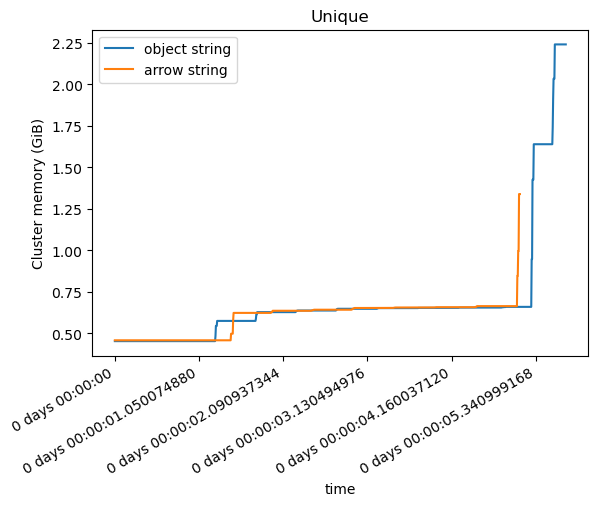

In [36]:
ms1.plot(align=True, title="Unique")

## Benchmark 2

In [48]:
client.restart();

2023-03-29 17:11:23,368 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:11:23,388 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:11:23,390 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:11:23,394 - distributed.nanny - WARNING - Restarting worker


In [49]:
# 2
with performance_report(filename=f"{report_dir}/2-object-group-count.html"):
    with ms2.sample("object string", interval=0.01):
        for _ in range(1):
            get_ddf(True).groupby("store_and_fwd_flag").count().compute()
            time.sleep(0.2)

In [50]:
client.restart();

2023-03-29 17:12:00,143 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:12:00,165 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:12:00,166 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:12:00,167 - distributed.nanny - WARNING - Restarting worker


In [51]:
# 2, ddf2
with performance_report(filename=f"{report_dir}/2-string-group-count.html"):
    with ms2.sample("arrow string", interval=0.01):
        for _ in range(1):
            get_ddf2(True).groupby("store_and_fwd_flag").count().compute()
            time.sleep(0.2)

<Axes: title={'center': 'Groupby/count'}, xlabel='time', ylabel='Cluster memory (GiB)'>

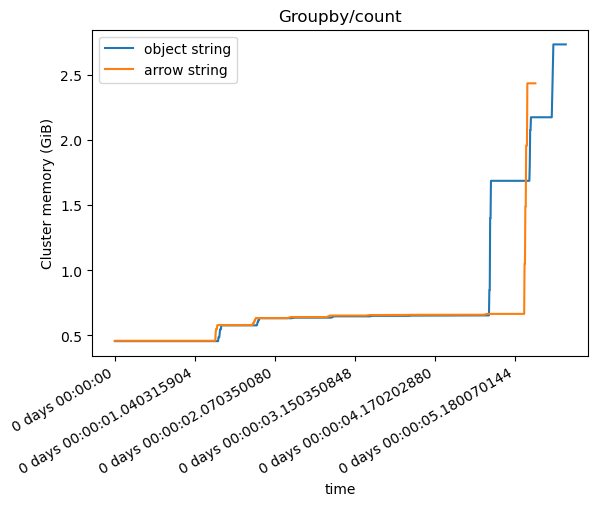

In [52]:
ms2.plot(align=True, title="Groupby/count")

## Benchmark 3

In [55]:
client.restart();

2023-03-29 17:16:32,814 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:16:32,826 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:16:32,828 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:16:32,829 - distributed.nanny - WARNING - Restarting worker


In [56]:
# 3
with performance_report(filename=f"{report_dir}/3-object-startswith.html"):
    with ms3.sample("object string", interval=0.01):
        for _ in range(1):
            get_ddf(True).store_and_fwd_flag.str.startswith("a").compute()
            time.sleep(0.2)

In [57]:
client.restart();

2023-03-29 17:18:38,505 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:18:38,528 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:18:38,594 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:18:38,604 - distributed.nanny - WARNING - Restarting worker


In [58]:
# 3, ddf2
with performance_report(filename=f"{report_dir}/3-string-startswith.html"):
    with ms3.sample("arrow string", interval=0.01):
        for _ in range(1):
            get_ddf2(True).store_and_fwd_flag.str.startswith("a").compute()
            time.sleep(0.2)

<Axes: title={'center': 'String startswith'}, xlabel='time', ylabel='Cluster memory (GiB)'>

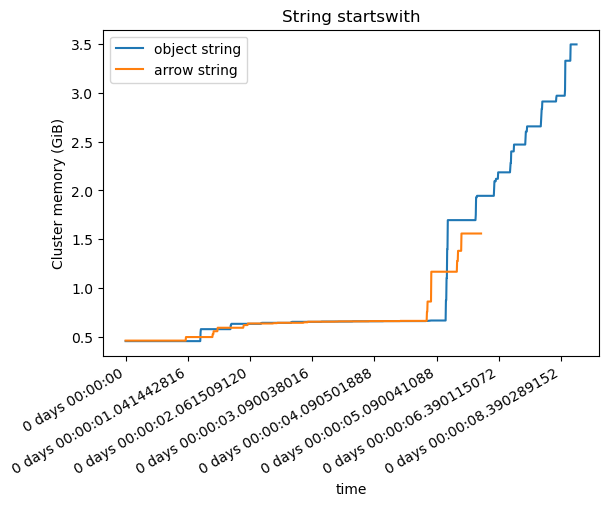

In [65]:
ms3.plot(align=True, title="String startswith")

## Benchmark 4

In [60]:
client.restart();

2023-03-29 17:20:30,677 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:20:30,693 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:20:30,694 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:20:30,695 - distributed.nanny - WARNING - Restarting worker


In [61]:
# 4
with performance_report(filename=f"{report_dir}/4-object-strlen.html"):
    with ms4.sample("object string", interval=0.01):
        for _ in range(1):
            get_ddf(True).store_and_fwd_flag.str.len().compute()
            time.sleep(0.2)

In [62]:
client.restart();

2023-03-29 17:21:09,466 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:21:09,495 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:21:09,496 - distributed.nanny - WARNING - Restarting worker
2023-03-29 17:21:09,497 - distributed.nanny - WARNING - Restarting worker


In [63]:
# 4, ddf2
with performance_report(filename=f"{report_dir}/4-string-strlen.html"):
    with ms4.sample("arrow string", interval=0.01):
        for _ in range(1):
            get_ddf2().store_and_fwd_flag.str.len().compute()
            time.sleep(0.2)

<Axes: title={'center': 'String length'}, xlabel='time', ylabel='Cluster memory (GiB)'>

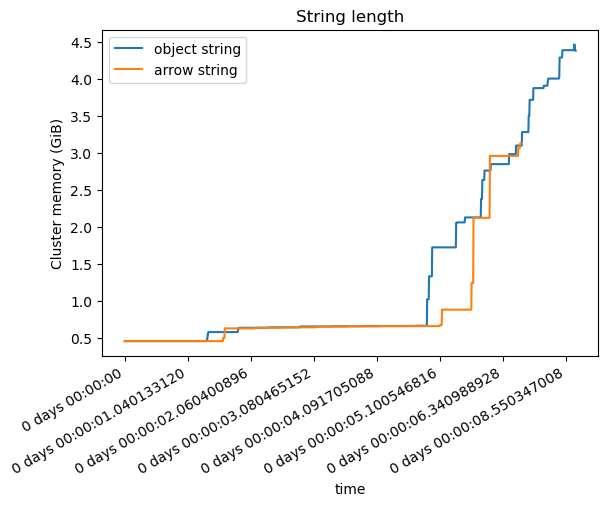

In [64]:
ms4.plot(align=True, title="String length")

In [108]:
client.close()

In [109]:
cluster.close()